## FPL Data Collector Agent

#### State

In [11]:
from typing import Dict, List, Literal, Optional
from datetime import datetime
from pydantic import BaseModel, Field
from langchain.schema import Document
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

In [12]:
# Define the workflow state
class WorkflowState(BaseModel):
    # Core state variables
    stage: Literal["collector", "analyzer", "decision"] = "collector"
    gameweek: Optional[int] = None
    deadline: Optional[datetime] = None
    error_log: Optional[List[str]] = Field(default_factory=list)

    # Data collector agent variables
    fpl_api_data: Dict = Field(default_factory=dict)
    news_search_data: List[Document] = Field(default_factory=list)

data_collector_graph = StateGraph(WorkflowState)

#### Tools

In [13]:
# FPL API tool
from httpx import AsyncClient
from typing import Dict


class FPLOfficialAPI:
    def __init__(
        self,
        base_url: str,
        session: AsyncClient,
        bootstrap_data: Dict
    ):
        self.base_url = base_url
        self.session = session
        self._bootstrap_data = bootstrap_data

    @classmethod
    async def create(cls) -> "FPLOfficialAPI":
        """Create an instance of FPLOfficialAPI with bootstrap data."""
        base_url = "https://fantasy.premierleague.com/api"
        session = AsyncClient()
        bootstrap_data = await cls.get_bootstrap_data(base_url, session)
        return cls(base_url, session, bootstrap_data)

    @staticmethod
    async def get_bootstrap_data(base_url, session) -> Dict:
        """Get basic FPL data including gameweeks, teams, players, chips..."""
        try:
            response = await session.get("{}/bootstrap-static/".format(base_url))
            response.raise_for_status()
            return response.json()
        except Exception as e:
            print("Error while getting bootstrap data:", e)

    async def get_gameweek_data(self) -> Dict:
        """Get info for the current gameweek and deadline."""
        if self._bootstrap_data is None:
            return {}

        # Get next gameweek from bootstrap data
        next_gw = None
        for gw in self._bootstrap_data.get("events", []):
            if gw["is_next"]:
                next_gw = gw
                break

        # Get fixtures for the current gameweek
        fixtures = await self.get_fixtures()
        if not fixtures:
            return {}

        # Filter fixtures for the next gameweek
        next_gw_fixtures = [
            fixture for fixture in fixtures if fixture.get("event") == next_gw.get("id")
        ] if next_gw else []

        return {
            "gameweek": next_gw.get("id") if next_gw else None,
            "deadline": next_gw.get("deadline_time") if next_gw else None,
            "finished": next_gw.get("finished") if next_gw else False,
            "fixtures": next_gw_fixtures
        }

    async def get_fixtures(self) -> Dict:
        """Get fixtures for the season."""
        try:
            response = await self.session.get("{}/fixtures/".format(self.base_url))
            response.raise_for_status()
            return response.json()
        except Exception as e:
            print("Error getting fixture data:", e)


In [14]:
# FPL News Searcher tool
import os
from tavily import TavilyClient
from typing import Optional, List, Dict
from langchain.schema import Document
from langchain_community.document_loaders import UnstructuredURLLoader
from asyncio import to_thread
from dotenv import load_dotenv

#  Load environment variables
_ = load_dotenv()


class FPLNewsSearcher:
    # Required env variables for FPL news searcher
    REQUIRED_ENV_VARS = ["TAVILY_API_KEY"]

    def __init__(self):
        self.client =  TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
        self.news_docs: List[Document] = []

    async def search_news(self) -> List[Document]:
        await self._search_injury_news()
        await self._search_team_news()
        await self._search_fpl_news()
        return self.news_docs

    async def _search(self, query: str) -> Dict:
        return self.client.search(
            query=query,
            search_depth="advanced",
            max_results=3,
            topic="news",
            include_raw_content=False
        )

    async def _search_and_load_docs(self, queries: List[str], category: str = None) -> None:
        for query in queries:
            # Get the tavily api search results for each query
            response = await self._search(query)

            # Get the urls from the search results
            urls = [result["url"] for result in response.get("results", []) if "url" in result]

            if urls:
                # Fetch and parse the content from each URL
                loader = UnstructuredURLLoader(urls=urls)
                loaded_docs = await to_thread(loader.load)

                # Update documents' metadata
                for i, d in enumerate(loaded_docs):
                    d.metadata.update({
                        "source": urls[i],
                        "query": query,
                        "category": category
                    })

                # Extend the news_docs list with the new documents
                self.news_docs.extend(loaded_docs)

    async def _search_injury_news(self) -> None:
        await self._search_and_load_docs([
            "Premier League team news injury reports press conference updates",
        ], category="injury")

    async def _search_team_news(self) -> None:
        await self._search_and_load_docs([
            "Fantasy Premier League benching risks and squad news",
            "FPL rotation risk players starting XI updates",
        ], category="team")

    async def _search_fpl_news(self) -> None:
        await self._search_and_load_docs([
            "FPL Scout selection and transfer recommendations latest",
            "FPL Scout best tips and advice latest",
            "FPL captain picks latest expert analysis"
        ], category="fpl")


#### Nodes

In [15]:
async def fetch_fpl_data_node(state: WorkflowState) -> WorkflowState:
    """Fetch FPL data from the FPL Official API."""
    fpl_api = await FPLOfficialAPI.create()
    try:
        # Fetch gameweek relevant data
        gameweek_data = await fpl_api.get_gameweek_data()

        if gameweek_data is None:
            state.error_log.append("No gameweek data found.")
            return state

        # Update state with gameweek data
        state.gameweek = gameweek_data.get("gameweek")
        state.deadline = gameweek_data.get("deadline")
        state.fpl_api_data.update(gameweek_data)

    except Exception as e:
        state.error_log.append(f"Error fetching FPL data: {e}")

    return state

async def search_news_node(state: WorkflowState) -> WorkflowState:
    """Search for news data using the news searcher tool."""
    news_searcher = FPLNewsSearcher()
    try:
        # Search for news
        news_docs = await news_searcher.search_news()

        if not news_docs:
            state.error_log.append("No news documents found.")
            return state

        # Update state with news documents
        state.news_search_data.extend(news_docs)

    except Exception as e:
        state.error_log.append(f"Error searching news: {e}")

    return state

#### Graph

In [16]:
# Add nodes to the graph
data_collector_graph.add_node("fetch_fpl_data_node", fetch_fpl_data_node)
data_collector_graph.add_node("search_news_node", search_news_node)

# Add edges
data_collector_graph.add_edge(START, "fetch_fpl_data_node")
data_collector_graph.add_edge("fetch_fpl_data_node", "search_news_node")
data_collector_graph.add_edge("search_news_node", END)

# Compile the graph
data_collector_graph_builder = data_collector_graph.compile()

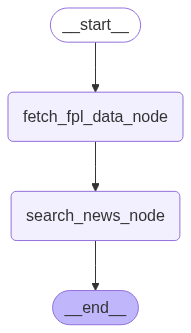

In [17]:
# Display the graph
display(Image(data_collector_graph_builder.get_graph().draw_mermaid_png()))

In [18]:
# Test the graph
data_collector_state = await data_collector_graph_builder.ainvoke(WorkflowState().model_dump())
data_collector_state

{'stage': 'collector',
 'gameweek': 2,
 'deadline': datetime.datetime(2025, 8, 22, 17, 30, tzinfo=TzInfo(UTC)),
 'error_log': [],
 'fpl_api_data': {'gameweek': 2,
  'deadline': '2025-08-22T17:30:00Z',
  'finished': False,
  'fixtures': [{'code': 2561914,
    'event': 2,
    'finished': False,
    'finished_provisional': False,
    'id': 20,
    'kickoff_time': '2025-08-22T19:00:00Z',
    'minutes': 0,
    'provisional_start_time': False,
    'started': False,
    'team_a': 7,
    'team_a_score': None,
    'team_h': 19,
    'team_h_score': None,
    'stats': [],
    'team_h_difficulty': 3,
    'team_a_difficulty': 2,
    'pulse_id': 124810},
   {'code': 2561912,
    'event': 2,
    'finished': False,
    'finished_provisional': False,
    'id': 18,
    'kickoff_time': '2025-08-23T11:30:00Z',
    'minutes': 0,
    'provisional_start_time': False,
    'started': False,
    'team_a': 18,
    'team_a_score': None,
    'team_h': 13,
    'team_h_score': None,
    'stats': [],
    'team_h_diff